# Cleaned exterior solver

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.2"
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import jax
import jax.numpy as jnp
import numpy as np
from scipy.io import savemat
import matplotlib.pyplot as plt
import h5py

from timeit import default_timer
import logging
logging.basicConfig(
    format="%(asctime)s.%(msecs)03d:jaxhps: %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.DEBUG
)

jax.config.update("jax_default_device", jax.devices("gpu")[0])
jax.config.update("jax_enable_x64", True)
# jax.config.update("XLA_PYTHON_CLIENT_MEM_FRACTION", 0.5)


import subprocess
_ =subprocess.run("hostname")
_ =subprocess.run(["nvidia-smi", "--query-gpu=gpu_name,memory.total",  "--format=csv,noheader"])

DEBUG:2025-07-01 17:05:49,403:jax._src.xla_bridge:536: Discovered path based JAX plugin: jax_plugins.xla_cuda12
2025-07-01 17:05:49.403:jaxhps: DEBUG - Discovered path based JAX plugin: jax_plugins.xla_cuda12
DEBUG:2025-07-01 17:05:49,433:jax._src.xla_bridge:545: Discovered entry-point based JAX plugin: jax_plugins.xla_cuda12
2025-07-01 17:05:49.433:jaxhps: DEBUG - Discovered entry-point based JAX plugin: jax_plugins.xla_cuda12
DEBUG:2025-07-01 17:05:49,435:jax._src.xla_bridge:551: Loading plugin module jax_plugins.xla_cuda12
2025-07-01 17:05:49.435:jaxhps: DEBUG - Loading plugin module jax_plugins.xla_cuda12
DEBUG:2025-07-01 17:05:49,452:jax._src.xla_bridge:662: registering PJRT plugin cuda from /share/data/willett-group/oortsang/miniconda/envs/jaxhps-env/lib/python3.10/site-packages/jax_plugins/xla_cuda12/xla_cuda_plugin.so
2025-07-01 17:05:49.452:jaxhps: DEBUG - registering PJRT plugin cuda from /share/data/willett-group/oortsang/miniconda/envs/jaxhps-env/lib/python3.10/site-package

g14.ttic.edu
NVIDIA RTX A6000, 49140 MiB


In [2]:
from src.jaxhps import (
    DiscretizationNode2D,
    Domain,
    PDEProblem,
    upward_pass_subtree,
    downward_pass_subtree,
    local_solve_chunksize_2D,
)
from src.jaxhps.local_solve import local_solve_stage_uniform_2D_ItI
from src.jaxhps.merge import merge_stage_uniform_2D_ItI
from src.jaxhps.down_pass import down_pass_uniform_2D_ItI

from src.wave_scattering.interp_utils import (
    prep_grids_cheb_2d,
    prep_grids_unif_2d,
    reorder_tree_cheb_for_hps,
)
from src.wave_scattering.interp_ops import (
    QuadtreeToUniform,
    UniformToQuadtree,
)
from src.wave_scattering.gen_SD_exterior import (
    gen_S_exterior,\
    gen_D_exterior,
)

from src.wave_scattering.exterior_solver import forward_model_exterior
from src.wave_scattering.scattering_utils import load_SD_matrices
from src.wave_scattering.HPSScatteringSolver import HPSScatteringSolver

In [3]:
bump_center = jnp.array([0.05, 0.1])
# bump_center = jnp.array([0.0, 0.0])
amplitude = 2
sigma = 0.15
# q_fn_handle = lambda x: amplitude * jnp.exp(-0.5*jnp.sum( ((x-bump_center)/sigma)**2 ,axis=-1))

q_fn_handle = lambda x: q_gaussian_bumps(1.5 * x)

## Load an entry from the MFISNets dataset

In [4]:
def load_hdf5_simple(fp):
    data_dict = dict()
    with h5py.File(fp, "r") as hf:
        data_dict = {key: val[()] for (key, val) in hf.items()}
    return data_dict

In [5]:
rlc_repo_dir = os.path.join("/home-nfs/oortsang", "rlc-repo")
dataset_dir = os.path.join(rlc_repo_dir, "dataset_1e-4_rho_max_0.575")
sample_fp = os.path.join(dataset_dir, "train_scattering_objs", "scattering_objs_0.h5")

scobj_dict = load_hdf5_simple(sample_fp)
N_x = scobj_dict["x_vals"].shape[0]

In [6]:
sample_idx = 0
q_cart_i = scobj_dict["q_cart"][sample_idx]

In [7]:
# Basic problem dimensions
# k_str = "100"
kbar_str = "8"
kbar = float(kbar_str)
k = 2*np.pi*kbar
R = 100
receiver_radius = R

N_s = 192
N_r = N_s

## Compute a reference with the Lippmann-Schwinger solver

In [8]:
import torch
import scipy.sparse.linalg
import sys, os, importlib.util

def module_importer(module_name, target_path):
    # See https://stackoverflow.com/questions/67631/how-can-i-import-a-module-dynamically-given-the-full-path
    target_path = os.path.abspath(os.path.expanduser(target_path))
    spec = importlib.util.spec_from_file_location(module_name, target_path)
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module

solvers = module_importer ("solvers", "~/rlc-repo/solvers/__init__.py")
src = module_importer ("src", "~/rlc-repo/src/__init__.py")

from solvers.integral_equation.HelmholtzSolverDifferentiable import (
    setup_differentiable_solver,
    HelmholtzSolverDifferentiable,
    PytorchPDESolver,
    NP_CDTYPE, TORCH_CDTYPE, TORCH_RDTYPE,
)

from src.utils.plotting_utils import plot_row
from src.utils.vram_info import get_memory_info, free_vram
from src.data.data_io import load_hdf5_to_dict, load_multifreq_dataset

import os
import sys
import time
import logging
from typing import Tuple, Callable, Dict
import IPython
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

get_memory_info()

import subprocess
_ = subprocess.run("hostname")
_ = subprocess.run(["nvidia-smi", "--query-gpu=gpu_name,memory.total",  "--format=csv,noheader"])

RAM Used (MB): 8191
VRAM (MB): 0 free of 0 reserved; 0 allocated out of 48669 total
g14.ttic.edu
NVIDIA RTX A6000, 49140 MiB


In [9]:
nu_solver  = k / (2*np.pi)
spatial_domain_max = 0.5
# q_si  = np.array(ref_main_q_clip_unif)
q_si = q_cart_i

print(f"Use frequency {nu_solver}*2pi")
solver_obj = setup_differentiable_solver(
    N_x, spatial_domain_max, nu_solver, receiver_radius,
    prepare_half_grid=True, device=device,
)

Use frequency 8.0*2pi
Calling find_diag_correction(h=5.2083e-03, frequency=50.27)...
Calling find_diag_correction(h=1.0417e-02, frequency=50.27)...


In [10]:
get_memory_info()
free_vram()
get_memory_info()

RAM Used (MB): 8407
VRAM (MB): 1955 free of 2080 reserved; 124 allocated out of 48669 total
RAM Used (MB): 8407
VRAM (MB): 35 free of 160 reserved; 124 allocated out of 48669 total


In [11]:
restart = 2000 # 0 # 1000 # try not restarting...
batch_size = 96
max_iter = 20_000

rtol_ref = 1e-6
verbose = False

# Extra evaluation information
uin = solver_obj._get_uin(torch.tensor(solver_obj.source_dirs, device=device))
uin_int_ls = jnp.array(uin.detach().cpu().numpy()).T.reshape(N_x, N_x, N_s)

tq_si = torch.tensor(q_si, dtype=torch.float, device=device, requires_grad=False)
tqf_si = tq_si.flatten().unsqueeze(-1) # flattened
b_si  = -(solver_obj.frequency**2 * tqf_si * uin.permute(1, 0)).to(TORCH_CDTYPE)

def _matvec_from_torch_si(x: torch.Tensor, so=solver_obj) -> torch.Tensor:
    g_out = so._G_apply(x)
    y = x + (so.frequency**2 * tqf_si * g_out).to(TORCH_CDTYPE)
    return y

t0 = time.perf_counter()
d_rs_ref, sigma_ref = solver_obj.Helmholtz_solve_exterior_batched(
    tq_si,
    batch_size=batch_size,
    rtol=rtol_ref,
    linsys_solver="bicgstab",
    max_iter=max_iter,
    return_as_torch=False,
    return_sigma=True,
    error_unless_converged=False,
    convergence_by_dir=True,
    use_half_grid=True, # try not to boost the accuracy too much
    half_grid_tol_ratio=1,
    report_status=True,
    verbose=verbose,
    restart=restart,
)
t1 = time.perf_counter()
usc_ext_ls = jnp.array(d_rs_ref) # .T
usc_int_ls = jnp.array(
    solver_obj._G_apply(torch.tensor(sigma_ref,device=device).T)
    .reshape(N_x, N_x, N_s)
    .detach().cpu().numpy()
)
utot_int_ls = usc_int_ls + uin_int_ls

Asig_ref   = _matvec_from_torch_si(torch.tensor(sigma_ref, device=device).T)
resid_ref  = torch.norm( Asig_ref - b_si , dim=0 ) / torch.norm(b_si, dim=0)
resid_ref_min = resid_ref.min().item()
resid_ref_max = resid_ref.max().item()
print(f"BiCGSTAB at rtol={rtol_ref:.2e}: PDE solver ran for {t1-t0:.2f}s")
print(f"Relative residuals range between {resid_ref_min:.3e} to {resid_ref_max:.3e}")

2025-07-01 17:05:56.826:jaxhps: DEBUG - _solve_Helmholtz_inv: starting (using bicgstab)
2025-07-01 17:06:03.528:jaxhps: INFO - bicgstab exited after 898 iterations with status optimal
2025-07-01 17:06:03.534:jaxhps: DEBUG - _solve_Helmholtz_inv: returning
2025-07-01 17:06:03.605:jaxhps: DEBUG - _solve_Helmholtz_inv: starting (using bicgstab)


bicgstab exited after 898 iterations with status optimal


2025-07-01 17:06:18.282:jaxhps: INFO - bicgstab exited after 584 iterations with status optimal
2025-07-01 17:06:18.286:jaxhps: DEBUG - _solve_Helmholtz_inv: returning
2025-07-01 17:06:18.292:jaxhps: DEBUG - _solve_Helmholtz_inv: starting (using bicgstab)


bicgstab exited after 584 iterations with status optimal


2025-07-01 17:06:24.159:jaxhps: INFO - bicgstab exited after 879 iterations with status optimal
2025-07-01 17:06:24.163:jaxhps: DEBUG - _solve_Helmholtz_inv: returning
2025-07-01 17:06:24.223:jaxhps: DEBUG - _solve_Helmholtz_inv: starting (using bicgstab)


bicgstab exited after 879 iterations with status optimal


2025-07-01 17:06:36.894:jaxhps: INFO - bicgstab exited after 497 iterations with status optimal
2025-07-01 17:06:36.897:jaxhps: DEBUG - _solve_Helmholtz_inv: returning


bicgstab exited after 497 iterations with status optimal
BiCGSTAB at rtol=1.00e-06: PDE solver ran for 40.14s
Relative residuals range between 1.057e-06 to 1.500e-06


## Try with the HPS solver...

In [12]:
ext_factor = 2
N_x_quad = int(N_x * ext_factor) # extended domain for HPS to operate on
L = 4
p = 12 # chebyshev order
pm2 = p-2 # gauss-legendre order
n_per_leaf = int(np.round(N_x_quad / (2**L)))
nside = 2**L
n = nside * n_per_leaf

source_dirs = jnp.pi/2-jnp.linspace(0, 2*jnp.pi, N_s, endpoint=False)

# q_fn = q_fn_handle
main_clip_domain_bounds = jnp.array([-0.5, 0.5, -0.5, 0.5])
main_clip_unif_x, main_clip_unif_y, main_clip_unif_xy = prep_grids_unif_2d(
    0, N_x,
    main_clip_domain_bounds,
    rel_offset=0
)

main_quad_domain_bounds = ext_factor * main_clip_domain_bounds # jnp.array([-1., 1., -1., 1.])
main_quad_root = DiscretizationNode2D(*main_quad_domain_bounds)
main_quad_domain = Domain(p=p, q=p-2, root=main_quad_root, L=L) # Extended grid

main_quad_unif_x, main_quad_unif_y, main_quad_unif_xy = prep_grids_unif_2d(
    L, n_per_leaf,
    main_quad_domain_bounds,
    rel_offset=0
)
main_cheb_x, main_cheb_y, main_cheb_xy = prep_grids_cheb_2d(L, p, main_quad_domain_bounds)
main_hps_cheb_xy = reorder_tree_cheb_for_hps(main_cheb_xy, L, p)

In [13]:
%%time
UtQ = UniformToQuadtree(
    L, p, N_x,
    unif_domain_bounds=main_clip_domain_bounds,
    quad_domain_bounds=main_quad_domain_bounds,
    rel_offset=0,
)

CPU times: user 24 s, sys: 5.38 s, total: 29.4 s
Wall time: 12.5 s


In [14]:
%%time
QtU = QuadtreeToUniform(
    L, p, n_per_leaf, N_x,
    quad_domain_bounds=main_quad_domain_bounds,
    clip_domain_bounds=main_clip_domain_bounds,
    rel_offset=0,
)

CPU times: user 3 s, sys: 426 ms, total: 3.43 s
Wall time: 2.74 s


In [15]:
# Get the reference values with the help of the interpolation operators
ref_main_q_cheb = UtQ.apply(q_cart_i)
ref_main_q_clip_unif = q_cart_i

In [16]:
SD_matrices_dir = os.path.join(rlc_repo_dir, "rlc_data", "HPS_SD_matrices")
SD_matrices_fp = os.path.join(
    SD_matrices_dir,
    f"SD_kbar{kbar_str}_L{L}_n{pm2}_dom1.mat"
)
S_int, D_int = load_SD_matrices(SD_matrices_fp)

# Generate the exterior S, D matrices
S_ext = gen_S_exterior(domain=main_quad_domain, k=k, rad=R, source_dirs=source_dirs)
D_ext = gen_D_exterior(domain=main_quad_domain, k=k, rad=R, source_dirs=source_dirs)

In [17]:
%%time
hps_scattering_solver_original = HPSScatteringSolver(
    L=L, p=p, N_x=N_x, k=k,
    S_int=S_int,
    D_int=D_int,
    N_r=N_r,
    N_s=N_s,
    unif_domain_bounds = (-0.5, 0.5, -0.5, 0.5),
    quad_domain_bounds = (-0.5, 0.5, -0.5, 0.5),
    # UtQ=main_UtQ, # optional
)

2025-07-01 17:07:03.565:jaxhps: INFO - ScatteringProblem: cheby_weights_2D_rearranged shape: (1, 144)
2025-07-01 17:07:03.663:jaxhps: INFO - ScatteringProblem: self.quad_weights_hps shape: (256, 144)
2025-07-01 17:07:03.664:jaxhps: INFO - ScatteringProblem: self.pde_problem.domain.interior_points.shape: (256, 144, 2)


CPU times: user 5.5 s, sys: 748 ms, total: 6.25 s
Wall time: 5.19 s


In [18]:
%%time
# May run faster but only because it's not dealing with the compilation time
hps_scattering_solver_extended = HPSScatteringSolver(
    L=L, p=p, N_x=N_x, k=k,
    S_int=S_int,
    D_int=D_int,
    N_r=N_r,
    N_s=N_s,
    unif_domain_bounds = (-0.5, 0.5, -0.5, 0.5),
    quad_domain_bounds = (-1., 1., -1., 1.),
    UtQ=UtQ, # optional
)

2025-07-01 17:07:05.486:jaxhps: INFO - ScatteringProblem: cheby_weights_2D_rearranged shape: (1, 144)
2025-07-01 17:07:05.488:jaxhps: INFO - ScatteringProblem: self.quad_weights_hps shape: (256, 144)
2025-07-01 17:07:05.488:jaxhps: INFO - ScatteringProblem: self.pde_problem.domain.interior_points.shape: (256, 144, 2)


CPU times: user 787 ms, sys: 77.1 ms, total: 865 ms
Wall time: 590 ms


In [19]:
%%time
_, d_rs_hps_original = hps_scattering_solver_original.solve_exterior(q_cart_i)

2025-07-01 17:07:06.777:jaxhps: DEBUG - merge_stage_uniform_2D_ItI: T_arr.shape = (256, 40, 40)


CPU times: user 8.59 s, sys: 340 ms, total: 8.93 s
Wall time: 9.91 s


In [20]:
%%time
# Similarly, this is expected to be faster since it does not deal with first-time JIT compilation
_, d_rs_hps_extended = hps_scattering_solver_extended.solve_exterior(q_cart_i)

2025-07-01 17:07:15.456:jaxhps: DEBUG - merge_stage_uniform_2D_ItI: T_arr.shape = (256, 40, 40)


CPU times: user 90.3 ms, sys: 35.3 ms, total: 126 ms
Wall time: 138 ms


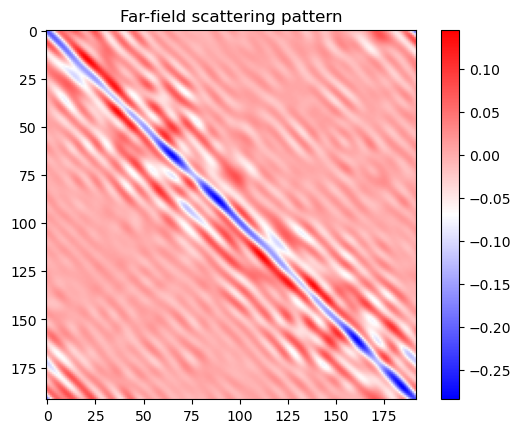

In [21]:
plt.title("Far-field scattering pattern")
plt.imshow(jnp.real(d_rs_hps_extended), cmap="bwr")
plt.colorbar()
plt.show()

## Comparison

In [22]:
d_rs_err_original = np.linalg.norm((d_rs_hps_original - d_rs_ref)) / np.linalg.norm((d_rs_ref))
print(f"Relative error (original quadtree): {d_rs_err_original:.5e}")

Relative error (original quadtree): 5.53856e-02


In [23]:
d_rs_err_extended = np.linalg.norm((d_rs_hps_extended - d_rs_ref)) / np.linalg.norm((d_rs_ref))
print(f"Relative error (original quadtree): {d_rs_err_extended:.5e}")

Relative error (original quadtree): 5.29607e-03


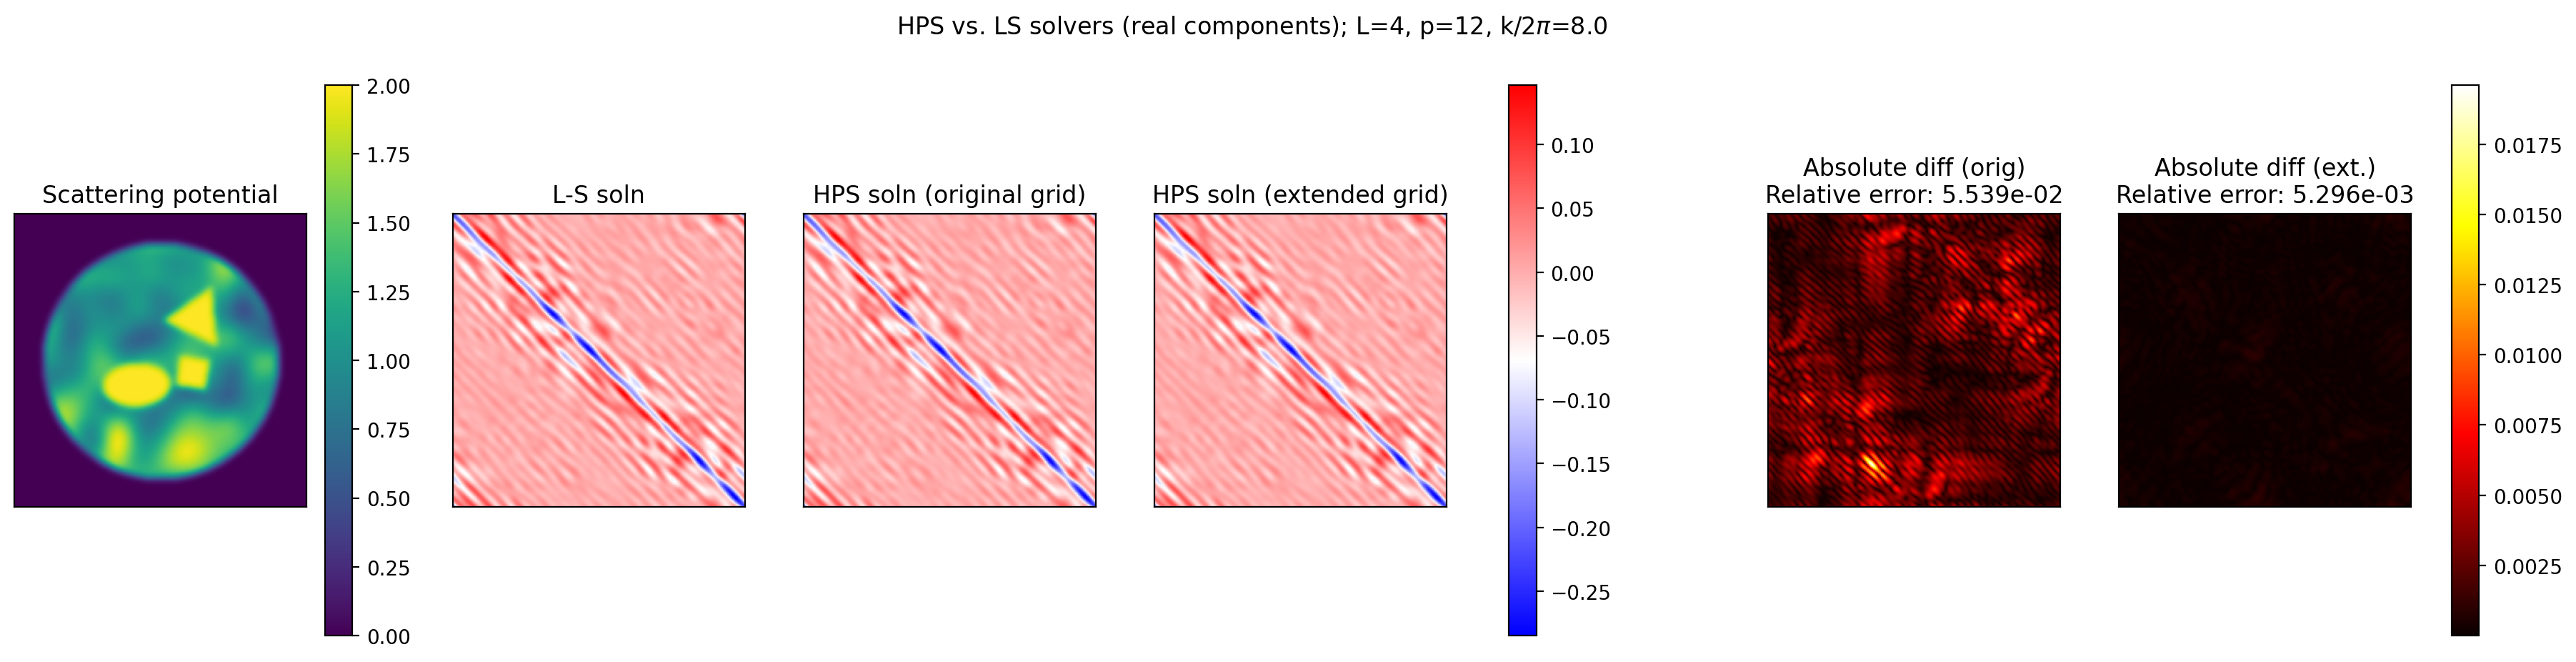

In [24]:
fig, axes = plot_row(
    [
        ref_main_q_clip_unif,
        jnp.real(d_rs_ref),
        jnp.real(d_rs_hps_original),
        jnp.real(d_rs_hps_extended),
        jnp.abs(d_rs_hps_original-d_rs_ref),
        jnp.abs(d_rs_hps_extended-d_rs_ref),
    ],
    [
        "Scattering potential",
        "L-S soln",
        "HPS soln (original grid)",
        "HPS soln (extended grid)",
        f"Absolute diff (orig)\nRelative error: {d_rs_err_original:.3e}",
        f"Absolute diff (ext.)\nRelative error: {d_rs_err_extended:.3e}",
    ],
    cmap_group_lens=[1,3,2],
    group_cmaps=["viridis", "bwr", "hot"],
    subplot_width=3.5,
    subplot_height=3,
    extra_fig_height=2,
    plt_subplots_kw={"dpi": 200},
)
fig.suptitle(f"HPS vs. LS solvers (real components); L={L}, p={p}, k/2$\\pi$={kbar:.1f}")
for ax in axes:
    ax.set_aspect(1)
plt.show()